In [1]:
import pandas as pd
import html5lib
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [2]:
bitcoin_price = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130101&end="+time.strftime("%Y%m%d"))[0]
bitcoin_price = bitcoin_price.assign(Date=pd.to_datetime(bitcoin_price["Date"]))
bitcoin_price.loc[bitcoin_price['Volume']=='-', 'Volume'] = 0
bitcoin_price['Volume'] = bitcoin_price['Volume'].astype('int64')
bitcoin_price.columns = bitcoin_price.columns.str.replace("*", "")
bitcoin_price.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2019-11-02,9259.78,9377.49,9249.59,9324.72,21242676385,168090392935
1,2019-11-01,9193.99,9275.66,9132.05,9261.10,24324691031,166928044164
2,2019-10-31,9202.46,9383.16,9028.72,9199.58,26583653947,165804227835
3,2019-10-30,9422.46,9426.87,9085.37,9205.73,27706531577,165899500650
4,2019-10-29,9248.44,9516.18,9232.65,9427.69,28426779937,169883866262


In [3]:
kwargs = {'OHLC_avg': lambda x: (x['Open'] + x['High'] + x['Low'] + x['Close'])/4}
bitcoin_price = bitcoin_price.assign(**kwargs)
bitcoin_price = bitcoin_price.sort_values(by='Date')
bitcoin_price.head()

,Date,Open,High,Low,Close,Volume,Market Cap,OHLC_avg
2379,2013-04-28,135.30,135.98,132.10,134.21,0,1488566728,134.3975
2378,2013-04-29,134.44,147.49,134.00,144.54,0,1603768865,140.1175
2377,2013-04-30,144.00,146.93,134.05,139.00,0,1542813125,140.9950
2376,2013-05-01,139.00,139.89,107.72,116.99,0,1298954594,125.9000
2375,2013-05-02,116.38,125.60,92.28,105.21,0,1168517495,109.8675


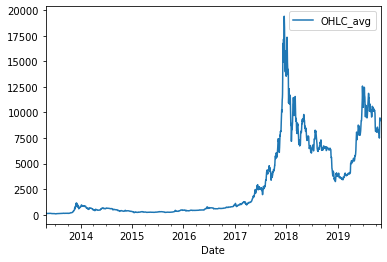

In [4]:
bitcoin_price.plot(x='Date', y="OHLC_avg")

In [5]:
data_length_in_days = (bitcoin_price.Date.values[-1] - bitcoin_price.Date.values[0]).astype('timedelta64[D]')
data_length_in_days

numpy.timedelta64(2379,'D')

In [6]:
split_point = bitcoin_price['Date'].values[0] + data_length_in_days * 0.8
split_point

numpy.datetime64('2018-07-14T00:00:00.000000000')

In [7]:
bitcoin_price_idx = bitcoin_price.set_index(["Date"], drop=True)
bitcoin_price_data = bitcoin_price_idx[['OHLC_avg']]
bitcoin_price_data_train = bitcoin_price_data[:split_point]
bitcoin_price_data_test = bitcoin_price_data[split_point:]
print(bitcoin_price_data_train.head())
print(bitcoin_price_data_test.head())

            OHLC_avg
Date                
2013-04-28  134.3975
2013-04-29  140.1175
2013-04-30  140.9950
2013-05-01  125.9000
2013-05-02  109.8675
             OHLC_avg
Date                 
2018-07-14  6258.5075
2018-07-15  6323.0775
2018-07-16  6549.3800
2018-07-17  7033.0250
2018-07-18  7375.3900


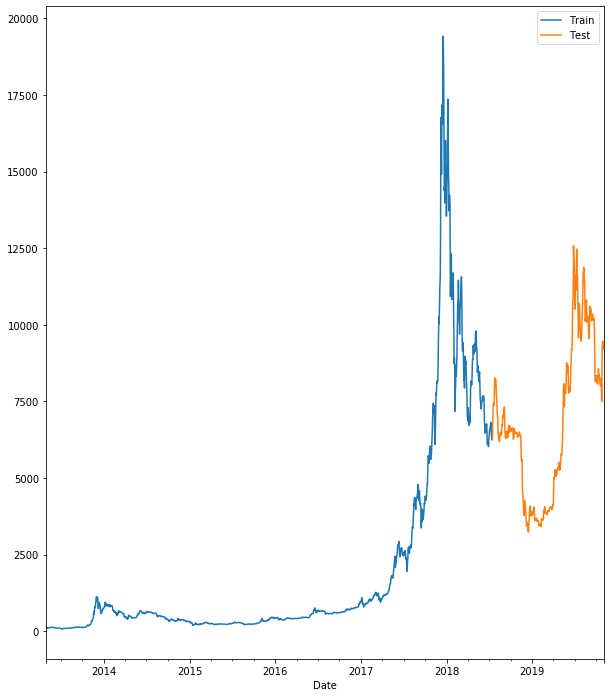

In [8]:
ax = bitcoin_price_data_train.plot(figsize=(10, 12))
bitcoin_price_data_test.plot(ax=ax)
plt.legend(['Train', 'Test'])
plt.show()

In [9]:
#Determine rolling statistics
rolmean = bitcoin_price_data.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = bitcoin_price_data.rolling(window=12).std()
print(rolmean,rolstd)

               OHLC_avg
Date                   
2013-04-28          NaN
2013-04-29          NaN
2013-04-30          NaN
2013-05-01          NaN
2013-05-02          NaN
...                 ...
2019-10-29  8442.278958
2019-10-30  8546.981458
2019-10-31  8647.484583
2019-11-01  8739.393958
2019-11-02  8827.927917

[2380 rows x 1 columns]               OHLC_avg
Date                  
2013-04-28         NaN
2013-04-29         NaN
2013-04-30         NaN
2013-05-01         NaN
2013-05-02         NaN
...                ...
2019-10-29  699.449481
2019-10-30  725.463348
2019-10-31  725.951069
2019-11-01  721.907466
2019-11-02  720.304287

[2380 rows x 1 columns]


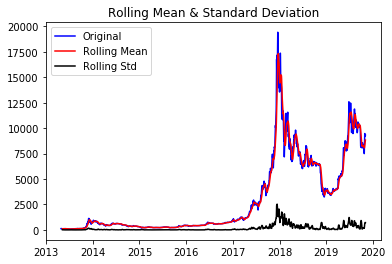

In [10]:
#Plot rolling statistics
original = plt.plot(bitcoin_price_data, color='blue', label='Original')
# A moving average is commonly used with time series data to smooth out short-term fluctuations and highlight longer-term trends or cycles.
roll_mean = plt.plot(rolmean, color='red', label='Rolling Mean')
# Moving Standard Deviation is a statistical measurement of market volatility. It makes no predictions of market direction, but it may serve as a confirming indicator. 
roll_standard = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [11]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

In [12]:
def test_stationarity(timeseries):
    moving_avg = timeseries.rolling(window=12).mean()
    moving_std = timeseries.rolling(window=12).std()
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(moving_avg, color='red', label='Rolling Mean')
    std = plt.plot(moving_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Results of Dicky Fuller Test:')
    dftest = adfuller(timeseries['OHLC_avg'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

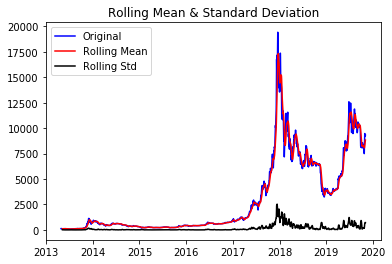

Results of Dicky Fuller Test:
Test Statistic                   -1.368220
p-value                           0.597414
#Lags Used                       27.000000
Number of Observations Used    2352.000000
Critical Value (1%)              -3.433133
Critical Value (5%)              -2.862770
Critical Value (10%)             -2.567425
dtype: float64


In [13]:
test_stationarity(bitcoin_price_data)

In [14]:
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

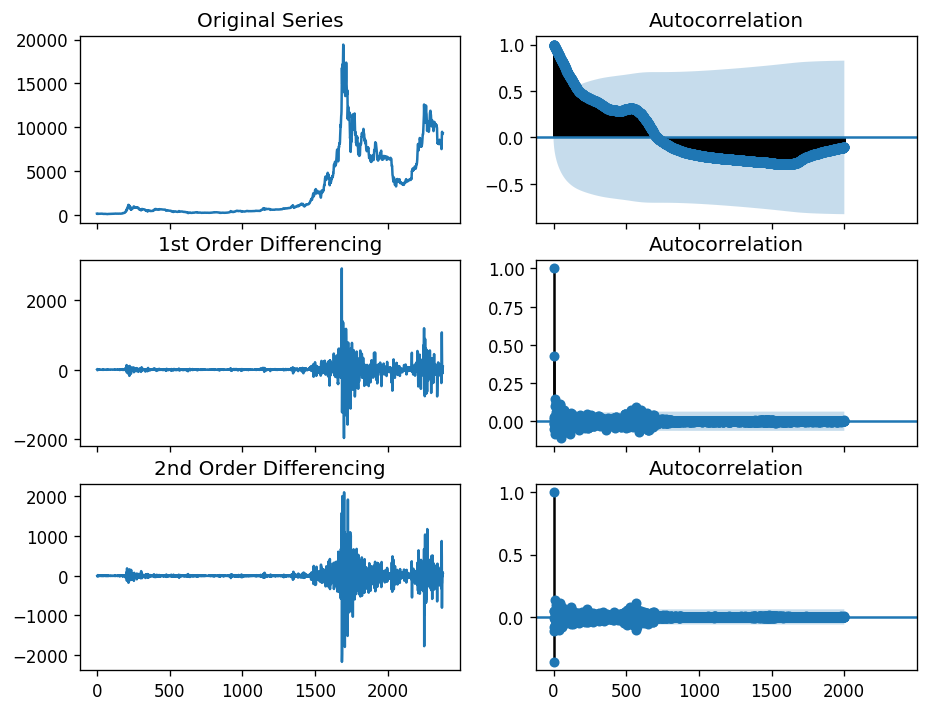

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9, 7), 'figure.dpi':120})

df = bitcoin_price["OHLC_avg"]
df.index = range(len(df.index))
# plot_acf(df, lags=2000)
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df)
axes[0, 0].set_title("Original Series")
plot_acf(df, lags=2000, ax=axes[0, 1])

axes[1, 0].plot(df.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.diff().dropna(), lags=2000, ax=axes[1, 1])

axes[2, 0].plot(df.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.diff().diff().dropna(), lags=2000, ax=axes[2, 1])

plt.show()


In [44]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

<Figure size 2220x1260 with 0 Axes>

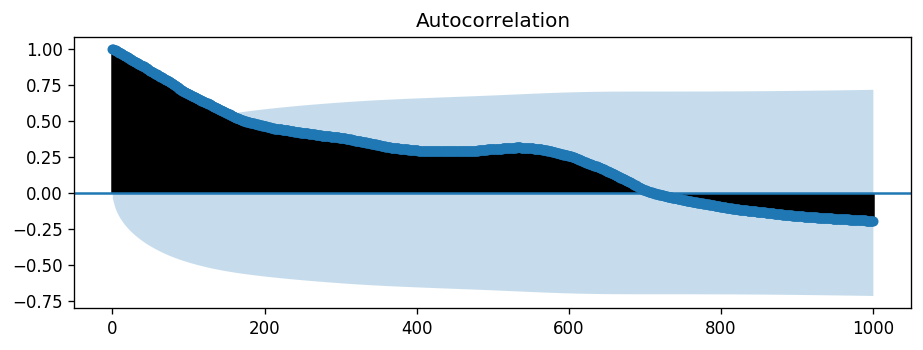

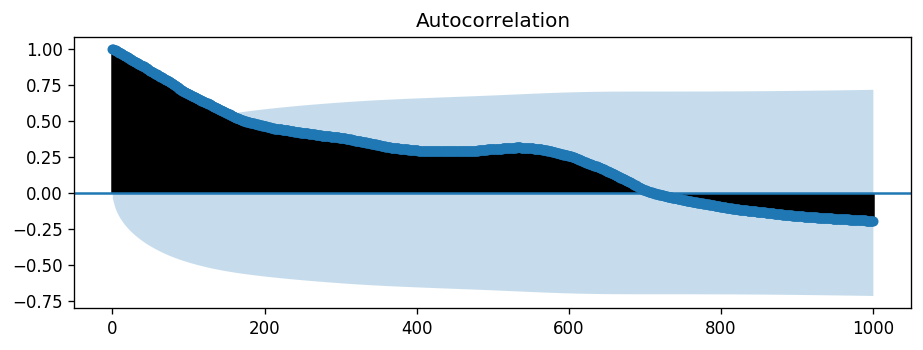

In [45]:
plot_acf(df.dropna(), lags=1000)

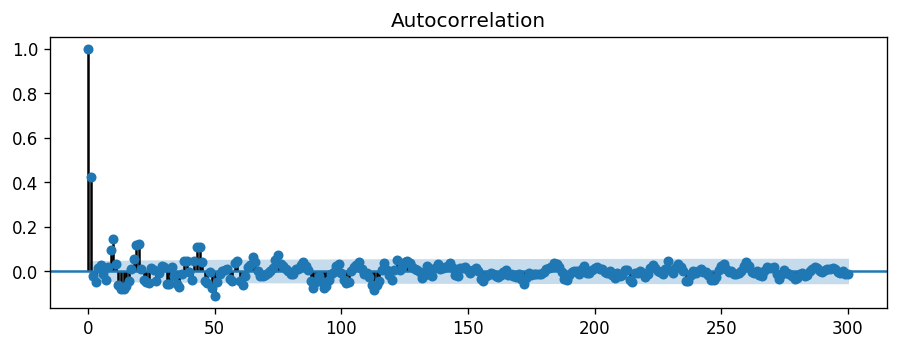

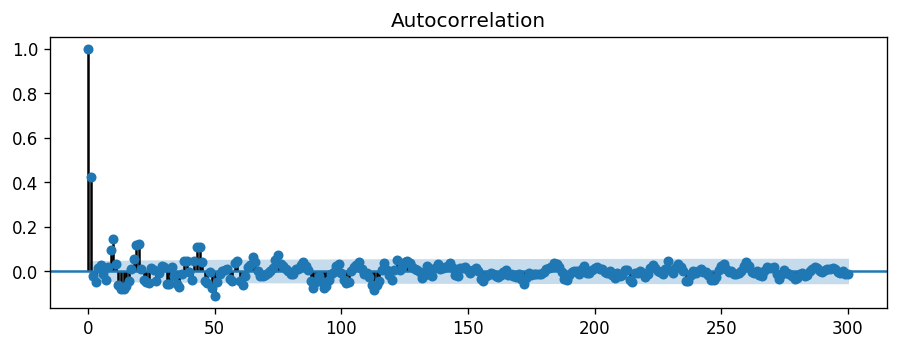

In [46]:
plot_acf(df.diff().dropna(), lags=300)

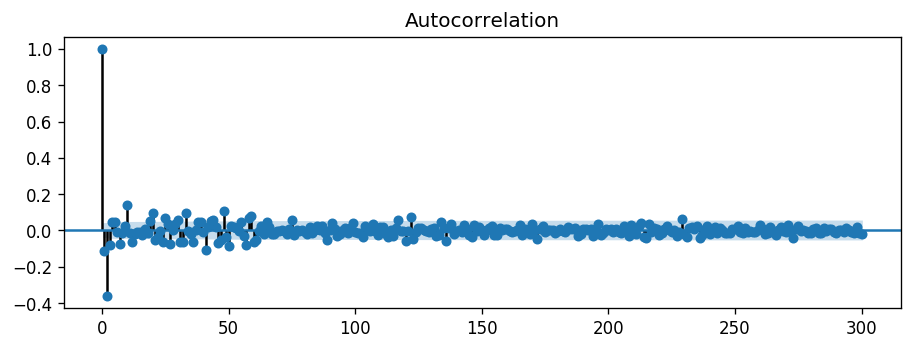

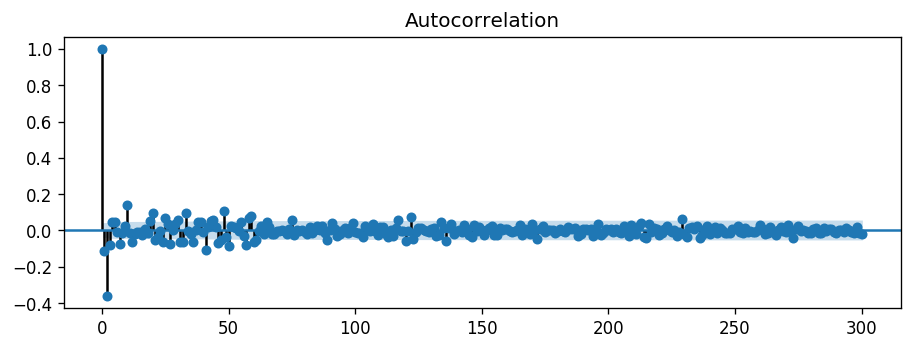

In [47]:
plot_acf(df.diff().diff().dropna(), lags=300)

In [32]:
# But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

In [48]:
from pmdarima.arima.utils import ndiffs
print(ndiffs(df, test='adf'))
print(ndiffs(df, test='kpss'))
print(ndiffs(df, test='pp'))

1
1
1


In [ ]:
# You can observe that the PACF lag 1 is quite significant since is well above the significance line. Lag 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region). But I am going to be conservative and tentatively fix the p as 1.

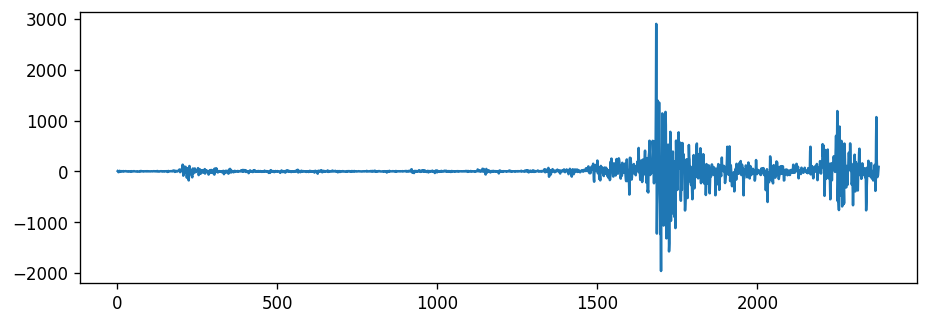

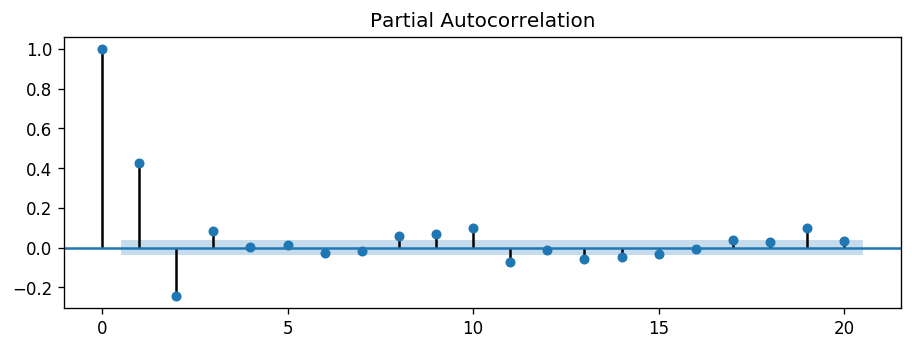

In [49]:
plt.plot(df.diff())
plot_pacf(df.diff().dropna(), lags=20)

plt.show()

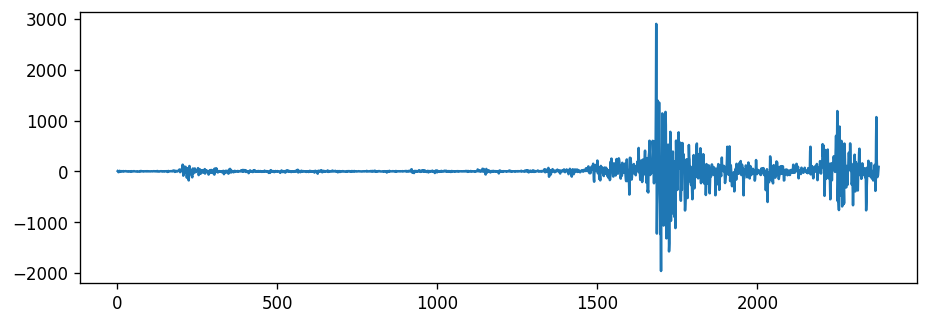

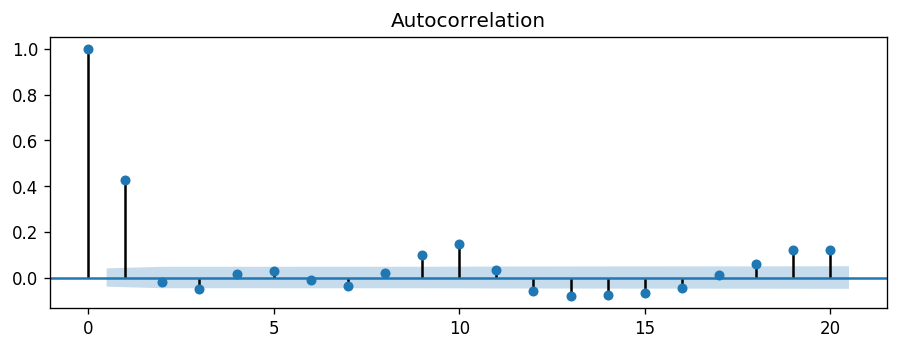

In [50]:
plt.plot(df.diff())
plot_acf(df.diff().dropna(), lags=20)

plt.show()

In [54]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df, order=(1, 1, 1))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:             D.OHLC_avg   No. Observations:                 2379
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -15525.037
Method:                       css-mle   S.D. of innovations            165.151
Date:                Sun, 03 Nov 2019   AIC                          31058.074
Time:                        23:20:46   BIC                          31081.172
Sample:                             1   HQIC                         31066.481
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.8540      5.381      0.716      0.474      -6.693      14.401
ar.L1.D.OHLC_avg     0.0710      0.035      2.007      0.045       0.002       0.140
ma.L1.D.OHLC_avg     0.4766 

In [53]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df, order=(2, 1, 1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# The model AIC has reduced, which is good. The P Values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05).

                             ARIMA Model Results                              
Dep. Variable:             D.OHLC_avg   No. Observations:                 2379
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -15520.071
Method:                       css-mle   S.D. of innovations            164.806
Date:                Sun, 03 Nov 2019   AIC                          31050.143
Time:                        23:20:14   BIC                          31079.015
Sample:                             1   HQIC                         31060.651
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.8674      5.011      0.772      0.440      -5.954      13.689
ar.L1.D.OHLC_avg     0.2504      0.070      3.577      0.000       0.113       0.388
ar.L2.D.OHLC_avg    -0.1263 

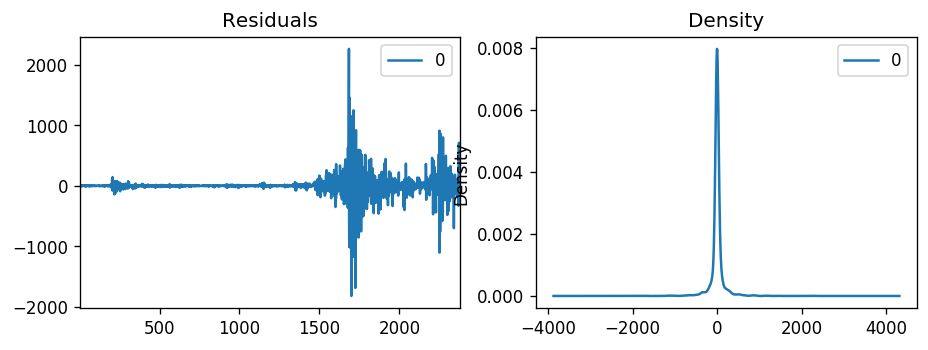

In [55]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

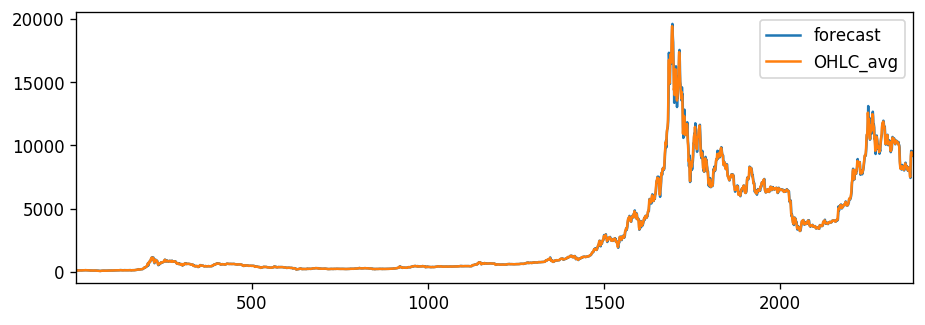

In [56]:
model_fit.plot_predict(dynamic=False)
plt.show()

Fit ARIMA: order=(2, 2, 2) seasonal_order=(1, 0, 1, 12); AIC=17393.970, BIC=17437.306, Fit time=4.040 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 12); AIC=18046.032, BIC=18056.866, Fit time=0.047 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 0, 0, 12); AIC=18026.050, BIC=18047.717, Fit time=0.933 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 1, 12); AIC=17982.231, BIC=18003.899, Fit time=1.063 seconds
Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 0, 1, 12); AIC=17397.661, BIC=17435.580, Fit time=2.416 seconds
Fit ARIMA: order=(2, 2, 2) seasonal_order=(2, 0, 1, 12); AIC=17386.760, BIC=17435.513, Fit time=9.383 seconds
Fit ARIMA: order=(2, 2, 2) seasonal_order=(2, 0, 0, 12); AIC=17385.721, BIC=17429.057, Fit time=6.183 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(2, 0, 0, 12); AIC=17388.430, BIC=17426.349, Fit time=6.446 seconds


/opt/anaconda3/envs/forDA_kernel/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: order=(3, 2, 2) seasonal_order=(2, 0, 0, 12); AIC=17388.290, BIC=17437.043, Fit time=12.805 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(2, 0, 0, 12); AIC=17434.644, BIC=17472.563, Fit time=7.699 seconds


/opt/anaconda3/envs/forDA_kernel/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 2, 3) seasonal_order=(2, 0, 0, 12); AIC=17389.006, BIC=17437.759, Fit time=17.151 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(2, 0, 0, 12); AIC=17525.273, BIC=17557.775, Fit time=10.367 seconds


/opt/anaconda3/envs/forDA_kernel/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 2, 3) seasonal_order=(2, 0, 0, 12); AIC=17390.144, BIC=17444.314, Fit time=21.018 seconds
Fit ARIMA: order=(2, 2, 2) seasonal_order=(1, 0, 0, 12); AIC=17395.966, BIC=17433.885, Fit time=2.712 seconds
Total fit time: 102.284 seconds


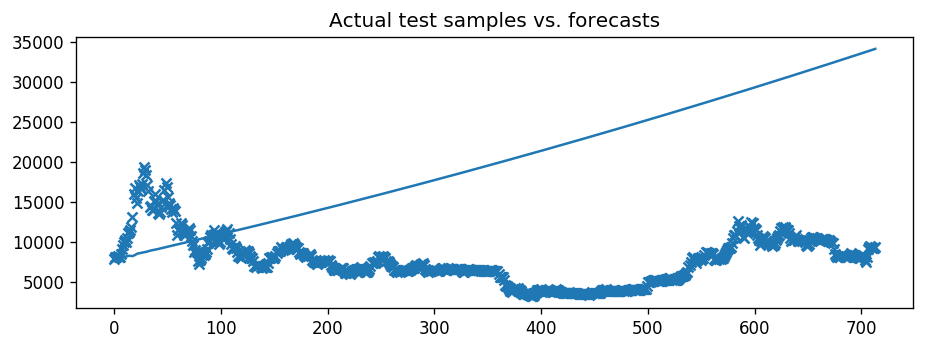

In [62]:
# second arima method: auto_arima
# https://www.alkaline-ml.com/pmdarima/auto_examples/example_simple_fit.html

import pmdarima as pm

df_split_point = int(len(df) * 0.7)
df_train, df_test = df[:df_split_point], df[df_split_point:]

arima = pm.auto_arima(df_train, error_action='ignore', trace=1, seasonal=True, m=12)

x = np.arange(df_test.shape[0])
plt.scatter(x, df_test, marker='x')
plt.plot(x, arima.predict(n_periods=df_test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()


In [16]:
# logged data
# arima_data_logScale = np.log(bitcoin_price_data)
# test_stationarity(arima_data_logScale)

In [17]:
# 𝑙𝑜𝑔𝑠𝑐𝑎𝑙𝑒𝐿=𝑠𝑡𝑎𝑡𝑖𝑜𝑛𝑎𝑟𝑦𝑝𝑎𝑟𝑡(𝐿1)+𝑡𝑟𝑒𝑛𝑑(𝐿𝑇) 
# 𝑚𝑜𝑣𝑖𝑛𝑔𝑎𝑣𝑔𝑜𝑓𝑙𝑜𝑔𝑠𝑐𝑎𝑙𝑒𝐴=𝑠𝑡𝑎𝑡𝑖𝑜𝑛𝑎𝑟𝑦𝑝𝑎𝑟𝑡(𝐴1)+𝑡𝑟𝑒𝑛𝑑(𝐴𝑇) 
# 𝑟𝑒𝑠𝑢𝑙𝑡𝑠𝑒𝑟𝑖𝑒𝑠𝑅=𝐿−𝐴=(𝐿1+𝐿𝑇)−(𝐴1+𝐴𝑇)=(𝐿1−𝐴1)+(𝐿𝑇−𝐴𝑇)
# moving_avg = bitcoin_price_data.rolling(window=12).mean()
# arima_data_after_minus = arima_data_logScale - moving_avg
# arima_data_after_minus.dropna(inplace=True)
# arima_data_after_minus.head(12)
# test_stationarity(arima_data_after_minus)